# Saliency and Grad-CAM Examples

[![Open In Colab <](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ShawnHymel/computer-vision-with-embedded-machine-learning/blob/master/2.3.1%20-%20CNN%20Visualizations/ei-saliency-and-grad-cam.ipynb)

Import a trained model (.zip file) from Edge Impulse and copy in post-processed features of a single sample image. Run the notebook to see a saliency map and Grad-CAM heatmap.

Saliency maps highlight which pixels in the input image were most important (i.e. most salient) in the decision making process.

Grad-CAM looks at the output feature map of the final convolution layer to figure out which areas of the image were the most important in the decision making process.

Author: EdgeImpulse, Inc.<br>
Date: June 19, 2021<br>
License: [Apache-2.0](apache.org/licenses/LICENSE-2.0)<br>

In [93]:
import numpy as np

import tensorflow as tf
from keras.models import load_model
from keras import activations, layers, models

import cv2

import matplotlib.pyplot as plt

In [ ]:
### Unzip model

# Change this based on your .zip model filename
model_zip_path = "/content/ei-electronic-components-cnn-nn-classifier-tensorflow-savedmodel-model.zip"

# Unzip in place
!unzip "{model_zip_path}"

In [184]:
### Settings

# Image resolution
width = 28
height = 28

# Labels
labels = ["background", "capacitor", "diode", "led", "resistor"]

# Paste ground processed features from Edge Impulse and set ground-truth label
img = [0.5758, 0.5758, 0.5730, 0.5735, 0.5758, 0.5723, 0.5730, 0.5735, 0.5758, 0.5811, 0.5894, 0.5886, 0.5893, 0.5905, 0.5897, 0.5883, 0.5841, 0.5858, 0.5839, 0.5874, 0.5857, 0.5883, 0.5980, 0.5940, 0.5952, 0.5945, 0.5975, 0.5939, 0.5758, 0.5730, 0.5758, 0.5753, 0.5719, 0.5758, 0.5781, 0.5788, 0.5867, 0.5906, 0.5924, 0.5944, 0.5952, 0.5952, 0.5957, 0.5901, 0.5891, 0.5931, 0.5970, 0.6014, 0.6009, 0.5980, 0.5952, 0.5968, 0.5991, 0.5975, 0.5945, 0.5980, 0.5758, 0.5758, 0.5753, 0.5723, 0.5781, 0.5811, 0.5834, 0.5897, 0.6005, 0.6003, 0.5963, 0.5940, 0.5957, 0.5968, 0.5986, 0.5956, 0.5945, 0.5975, 0.5975, 0.6049, 0.6072, 0.5986, 0.5991, 0.6044, 0.6032, 0.5980, 0.5940, 0.5952, 0.5758, 0.5758, 0.5719, 0.5758, 0.5824, 0.5824, 0.5887, 0.5975, 0.6003, 0.5998, 0.5963, 0.5991, 0.6044, 0.6037, 0.5986, 0.6021, 0.6009, 0.5954, 0.5936, 0.6049, 0.6067, 0.6044, 0.6049, 0.6014, 0.6003, 0.5963, 0.5980, 0.5998, 0.5735, 0.5719, 0.5735, 0.5765, 0.5839, 0.5963, 0.5945, 0.5968, 0.5963, 0.5986, 0.6021, 0.6067, 0.6072, 0.6067, 0.6049, 0.6073, 0.6088, 0.6095, 0.6049, 0.6055, 0.6032, 0.6037, 0.5986, 0.6021, 0.6032, 0.6009, 0.6021, 0.6032, 0.5792, 0.5799, 0.5804, 0.5788, 0.5868, 0.5980, 0.5998, 0.6009, 0.6044, 0.6067, 0.6067, 0.6060, 0.6037, 0.6067, 0.6127, 0.6096, 0.6049, 0.6068, 0.6060, 0.6060, 0.6079, 0.6056, 0.6088, 0.6088, 0.6072, 0.6076, 0.6060, 0.6037, 0.5822, 0.5838, 0.5845, 0.5845, 0.5910, 0.6003, 0.5986, 0.6021, 0.6067, 0.6037, 0.6037, 0.6091, 0.6102, 0.6129, 0.6124, 0.6159, 0.6118, 0.6141, 0.6184, 0.6239, 0.6188, 0.6083, 0.6125, 0.5982, 0.5966, 0.5918, 0.5953, 0.6017, 0.5746, 0.5845, 0.5820, 0.5873, 0.5950, 0.5994, 0.5991, 0.6044, 0.6055, 0.6072, 0.6092, 0.6148, 0.6102, 0.6078, 0.6152, 0.6171, 0.6206, 0.6253, 0.6230, 0.6222, 0.6209, 0.5962, 0.6277, 0.6335, 0.6064, 0.6200, 0.6138, 0.5894, 0.5792, 0.5845, 0.5913, 0.5936, 0.6003, 0.6009, 0.6026, 0.6055, 0.6102, 0.6126, 0.6121, 0.6202, 0.6191, 0.6156, 0.6151, 0.6184, 0.6224, 0.6169, 0.6164, 0.6299, 0.5086, 0.5466, 0.5792, 0.5166, 0.4570, 0.4199, 0.3628, 0.2960, 0.5788, 0.5827, 0.5913, 0.5943, 0.6014, 0.6067, 0.6044, 0.6028, 0.6014, 0.6131, 0.6240, 0.6400, 0.6397, 0.6436, 0.6454, 0.6484, 0.6502, 0.6468, 0.6454, 0.5440, 0.3328, 0.3567, 0.3325, 0.3003, 0.2872, 0.2940, 0.3302, 0.3963, 0.5792, 0.5822, 0.5934, 0.5980, 0.6037, 0.6055, 0.6021, 0.6170, 0.6297, 0.6103, 0.5900, 0.5661, 0.5207, 0.4933, 0.4995, 0.5085, 0.5378, 0.5577, 0.6108, 0.6151, 0.3047, 0.3255, 0.4440, 0.5153, 0.5669, 0.6011, 0.6270, 0.6402, 0.5815, 0.5892, 0.5903, 0.5991, 0.6067, 0.6021, 0.6273, 0.5668, 0.3964, 0.3412, 0.3150, 0.2468, 0.2456, 0.3070, 0.3013, 0.3024, 0.3237, 0.3106, 0.4624, 0.5329, 0.3516, 0.6046, 0.6652, 0.6468, 0.6379, 0.6344, 0.6266, 0.6192, 0.5834, 0.5839, 0.5929, 0.5975, 0.6009, 0.6197, 0.5714, 0.2976, 0.2595, 0.2769, 0.2862, 0.2664, 0.2622, 0.3113, 0.3149, 0.2984, 0.3460, 0.3887, 0.3581, 0.2832, 0.4869, 0.6425, 0.6335, 0.6339, 0.6270, 0.6298, 0.6301, 0.6211, 0.5857, 0.5943, 0.5980, 0.5975, 0.5963, 0.6346, 0.4181, 0.2420, 0.2781, 0.2478, 0.2830, 0.2641, 0.2629, 0.2931, 0.3144, 0.2583, 0.2412, 0.3120, 0.3991, 0.5332, 0.6272, 0.6362, 0.6362, 0.6344, 0.6298, 0.6309, 0.6280, 0.6171, 0.5874, 0.5963, 0.6003, 0.5986, 0.6037, 0.6147, 0.3346, 0.2512, 0.2888, 0.2733, 0.2745, 0.2780, 0.2675, 0.2907, 0.3132, 0.3352, 0.5190, 0.6257, 0.6495, 0.6542, 0.6374, 0.6316, 0.6298, 0.6301, 0.6289, 0.6309, 0.6268, 0.6206, 0.5811, 0.5938, 0.6049, 0.5963, 0.5991, 0.5855, 0.3104, 0.2546, 0.2744, 0.2680, 0.2710, 0.2850, 0.2850, 0.3001, 0.3035, 0.3918, 0.6380, 0.6386, 0.6284, 0.6362, 0.6379, 0.6270, 0.6261, 0.6249, 0.6266, 0.6309, 0.6252, 0.6171, 0.5811, 0.5862, 0.5924, 0.5952, 0.5991, 0.5688, 0.2986, 0.2535, 0.2814, 0.2841, 0.2981, 0.3054, 0.2755, 0.2704, 0.3070, 0.3535, 0.6282, 0.6574, 0.6632, 0.6277, 0.6113, 0.6466, 0.6286, 0.6257, 0.6289, 0.6309, 0.6215, 0.6078, 0.5869, 0.5918, 0.5947, 0.5921, 0.5907, 0.5611, 0.3014, 0.2488, 0.2934, 0.2685, 0.4215, 0.6029, 0.5294, 0.4149, 0.3475, 0.3174, 0.4540, 0.5310, 0.4487, 0.6183, 0.6562, 0.5355, 0.6333, 0.6263, 0.6247, 0.6344, 0.6342, 0.6249, 0.5850, 0.5799, 0.5839, 0.5852, 0.5852, 0.5585, 0.3181, 0.2336, 0.2743, 0.2904, 0.3193, 0.3611, 0.3739, 0.3382, 0.3105, 0.3058, 0.3058, 0.3262, 0.3433, 0.4692, 0.4692, 0.2329, 0.4307, 0.6238, 0.6056, 0.6094, 0.6005, 0.5898, 0.5765, 0.5737, 0.5824, 0.5842, 0.5863, 0.5669, 0.3662, 0.2140, 0.2372, 0.2512, 0.2593, 0.2455, 0.2361, 0.2458, 0.2550, 0.2516, 0.2370, 0.3197, 0.3766, 0.3163, 0.3069, 0.2706, 0.3077, 0.5783, 0.6532, 0.6676, 0.6228, 0.5853, 0.5774, 0.5825, 0.5831, 0.5824, 0.5829, 0.5788, 0.4258, 0.2240, 0.2184, 0.2176, 0.2276, 0.2382, 0.2377, 0.2242, 0.1901, 0.1495, 0.1887, 0.3206, 0.4256, 0.4989, 0.4674, 0.3187, 0.2619, 0.3551, 0.4554, 0.3596, 0.2542, 0.2215, 0.5797, 0.5931, 0.5892, 0.5847, 0.5847, 0.5854, 0.5100, 0.2413, 0.1502, 0.1804, 0.1796, 0.1636, 0.1455, 0.1391, 0.2075, 0.3473, 0.5057, 0.6182, 0.6555, 0.6518, 0.6499, 0.5517, 0.3382, 0.2390, 0.2267, 0.2735, 0.3554, 0.4504, 0.5834, 0.5858, 0.5913, 0.5842, 0.5863, 0.5838, 0.5820, 0.4693, 0.2463, 0.1631, 0.1729, 0.2175, 0.3235, 0.4607, 0.5707, 0.6353, 0.6370, 0.6344, 0.6301, 0.6305, 0.6159, 0.6184, 0.5912, 0.5544, 0.5771, 0.6232, 0.6483, 0.6511, 0.5811, 0.5850, 0.5952, 0.5882, 0.5835, 0.5823, 0.5831, 0.5935, 0.5789, 0.5346, 0.5499, 0.5961, 0.6313, 0.6390, 0.6326, 0.6257, 0.6252, 0.6275, 0.6316, 0.6355, 0.6277, 0.6117, 0.6141, 0.6254, 0.6273, 0.6148, 0.6144, 0.6194, 0.5834, 0.5839, 0.5986, 0.5979, 0.5901, 0.5905, 0.5921, 0.5986, 0.6095, 0.6173, 0.6227, 0.6266, 0.6242, 0.6203, 0.6260, 0.6211, 0.6251, 0.6286, 0.6321, 0.6321, 0.6243, 0.6206, 0.6247, 0.6188, 0.6143, 0.6145, 0.6151, 0.6157, 0.5788, 0.5886, 0.5973, 0.5994, 0.5980, 0.5980, 0.6021, 0.6032, 0.6079, 0.6080, 0.6161, 0.6255, 0.6219, 0.6165, 0.6161, 0.6219, 0.6195, 0.6259, 0.6305, 0.6236, 0.6102, 0.6130, 0.6199, 0.6175, 0.6183, 0.6141, 0.6131, 0.6072, 0.5753, 0.5874, 0.5816, 0.5811, 0.5911, 0.5980, 0.5963, 0.5986, 0.6049, 0.6056, 0.6165, 0.6137, 0.6102, 0.6141, 0.6165, 0.6176, 0.6044, 0.6079, 0.6188, 0.6211, 0.6102, 0.6055, 0.6124, 0.6156, 0.6113, 0.6032, 0.6067, 0.6095, 0.5758, 0.5765, 0.5742, 0.5723, 0.5776, 0.5931, 0.5957, 0.5963, 0.5986, 0.6060, 0.6102, 0.6072, 0.6060, 0.6137, 0.6130, 0.6055, 0.6037, 0.6037, 0.6055, 0.6055, 0.6106, 0.6055, 0.6118, 0.6180, 0.6125, 0.6060, 0.6060, 0.6037]
true_idx = 1  # Capacitor

# You probably don't need to change this
model_dir = "/content/saved_model"

In [185]:
### Load model file
model = load_model("saved_model")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dropout (Dropout)            (None, 784)               0         
_________________________________________________________________
y_pred (Dense)               (None, 5)                 3

Actual label: capacitor


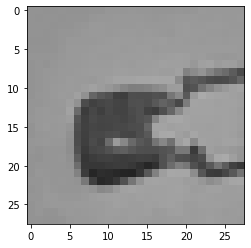

In [186]:
### Reshape image 

# Convert features to 2D Numpy array
img_reshape = np.reshape(np.array(img), (height, width))

# Show the ground-truth label
print("Actual label:", labels[true_idx])

# Display image (make sure we're looking at the right thing)
plt.imshow(img_reshape, cmap='gray', vmin=0.0, vmax=1.0)

In [187]:
### The Keras model expects images in a 4D array with dimensions (sample, height, width, channel)

# Add extra dimension to the image (placeholder for color channels)
img_0 = img_reshape.reshape(img_reshape.shape + (1,))

# Keras expects more than one image (in Numpy array), so convert image(s) to such array
images = np.array([img_0])

# Print dimensions of inference input
print(images.shape)

(1, 28, 28, 1)


In [188]:
### Do a forward pass (inference) with the test image and print the predicted probabilities

# Inference
preds = model.predict(images)

# Print out predictions
for i, pred in enumerate(preds[0]):
  print(labels[i] + ": " + str(pred))

background: 2.1412086e-05
capacitor: 0.9986557
diode: 8.566191e-05
led: 0.00076972664
resistor: 0.0004673557


In [189]:
### For either algorithm, we need to remove the Softmax activation function of the last layer
model.layers[-1].activation = None

## Saliency Map

In [190]:
### Based on: https://stackoverflow.com/questions/63107141/how-to-compute-saliency-map-using-keras-backend
def get_saliency_map(model, img_array, class_idx):

  # Record computations on a tape so we can compute the gradient given a particular input image
  with tf.GradientTape() as tape:
      tape.watch(img_array)
      predictions = model(img_array)
      loss = predictions[:, class_idx]
  
  # Compute the gradient of the loss with respect to the input image
  gradient = tape.gradient(loss, img_array)
  
  # Take maximum across channels
  gradient = tf.reduce_max(gradient, axis=-1)
  
  # Convert gradient to numpy
  gradient = gradient.numpy()
  
  # Normalize gradient to between 0.0 and 1.0
  min_val, max_val = np.min(gradient), np.max(gradient)
  smap = (gradient - min_val) / (max_val - min_val + keras.backend.epsilon())
  
  # Throw away the first dimension to get a single map the same shape as the input image
  return smap[0]

In [191]:
### Generate saliency map for the given input image
saliency_map = get_saliency_map(model, tf.convert_to_tensor(images), true_idx)

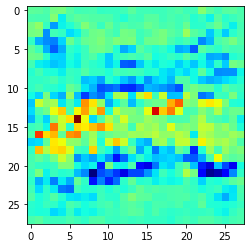

In [192]:
### Draw map
plt.imshow(saliency_map, cmap='jet', vmin=0.0, vmax=1.0)

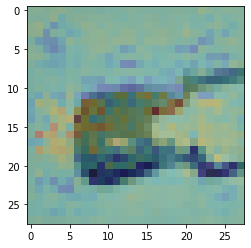

In [193]:
### Overlay the saliency map on top of the original input image
idx = 0
ax = plt.subplot()
ax.imshow(images[idx,:,:,0], cmap='gray', vmin=0.0, vmax=1.0)
ax.imshow(saliency_map, cmap='jet', alpha=0.25)

## Grad-CAM

In [194]:
### This function comes from https://keras.io/examples/vision/grad_cam/
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):

    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [195]:
### We need to tell Grad-CAM where to find the last convolution layer

# Print out the layers in the model
for layer in model.layers:
  print(layer, layer.name)

# Go backwards through the model to find the last convolution layer
last_conv_layer = None
for layer in reversed(model.layers):
  if isinstance(layer, layers.convolutional.Conv):
    last_conv_layer = layer.name
    break

# Give a warning if the last convolution layer could not be found
if last_conv_layer is not None:
  print("Last convolution layer found:", last_conv_layer)
else:
  print("ERROR: Last convolution layer could not be found. Do not continue.")

<keras.layers.convolutional.Conv2D object at 0x7f1a0e0f6e90> conv2d
<keras.layers.pooling.MaxPooling2D object at 0x7f1a0e11a9d0> max_pooling2d
<keras.layers.convolutional.Conv2D object at 0x7f1a0e18ea50> conv2d_1
<keras.layers.pooling.MaxPooling2D object at 0x7f1a0e06e490> max_pooling2d_1
<keras.layers.core.Flatten object at 0x7f1a0e07b790> flatten
<keras.layers.core.Dropout object at 0x7f1a0e09c850> dropout
<keras.layers.core.Dense object at 0x7f1a0dff66d0> y_pred
Last convolution layer found: conv2d_1


In [196]:
### Generate class activation heatmap
heatmap = make_gradcam_heatmap(images, model, last_conv_layer)

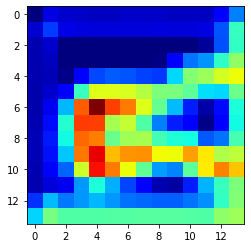

In [197]:
### Draw map
plt.imshow(heatmap, cmap='jet', vmin=0.0, vmax=1.0)

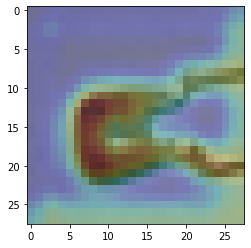

In [198]:
### Overlay the saliency map on top of the original input image

# The heatmap is a lot smaller than the original image, so we upsample it
big_heatmap = cv2.resize(heatmap, dsize=(height, width), interpolation=cv2.INTER_CUBIC)

# Draw original image with heatmap superimposed over it
idx = 0
ax = plt.subplot()
ax.imshow(images[idx,:,:,0], cmap='gray', vmin=0.0, vmax=1.0)
ax.imshow(big_heatmap, cmap='jet', alpha=0.25)